In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
import subprocess
from sklearn.base import clone

# Model Training

In [ ]:
df = pd.read_csv('data/train_filled_scaled.csv')

In [ ]:
X = df.drop(['offer_per','final_price'], axis=1)
y = df['offer_per']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### One time call

In [ ]:
#performance = pd.DataFrame(columns=['model','rmse_test','rmse_train'])
performance = pd.read_csv('data/performance.csv')

In [ ]:
def run_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, save=False, fit=True, model_name=None):
    if model_name is None:
        model_name = model.__class__.__name__

    if fit:
        model.fit(X_train, y_train)


    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))

    if save:
        performance.loc[len(performance)] = [model_name, rmse_test, rmse_train]

    print(f'{model_name} test RMSE: {rmse_test} train RMSE: {rmse_train}')


def run_gridsearch(model, param_grid, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, save=False,model_name=None, **kwargs):
    if model_name is None:
        model_name = model.__class__.__name__

    warnings.filterwarnings('ignore')
    gs = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', **kwargs,verbose=1)
    gs.fit(X_train, y_train)

    
    rmse_test = np.sqrt(mean_squared_error(y_test, gs.predict(X_test)))
    rmse_train = np.sqrt(mean_squared_error(y_train, gs.predict(X_train)))

    if save:
        performance.loc[len(performance)] = [model_name, rmse_test, rmse_train]

    
    send_notification(f'{model_name} test RMSE: {rmse_test} train RMSE: {rmse_train}')

    print(f'{model_name} test RMSE: {rmse_test} train RMSE: {rmse_train}', gs.best_params_)
    return gs


def send_notification(message='Task Completed'):
    subprocess.run(['notify-send' ,message])

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr_base = LinearRegression()

In [ ]:
run_model(lr_base, save=True)

LinearRegression test RMSE: 16.97084156936371 train RMSE: 16.63488559281818


In [ ]:
lr_base.coef_

array([-8.68611537e+00,  1.28366325e+01,  2.51368327e-04, -2.25693321e-03,
        8.39566887e-01, -3.43181316e+00,  1.82999476e+00,  2.10170069e+00,
       -3.87743173e-01,  2.45370878e+00,  3.43418680e+01, -6.33238062e+00,
        1.08846930e+00, -1.46526106e-02, -4.82586555e+00,  2.18992510e+00,
       -4.34369139e-01,  2.41966485e+00, -3.20566089e+00, -9.51461224e+00,
       -1.71184113e+00,  4.83756041e-01])

- let's apply some penality on the features that are not important, like norating, noreviews, one_star, two_star, three_star, four_star, five_star

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
eln_base = ElasticNet()

#### Grid Search

In [ ]:
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [ ]:
eln_grid = run_gridsearch(eln_base, param_grid, save=False)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
ElasticNet test RMSE: 16.97104946362114 train RMSE: 16.63489941289275 {'alpha': 0.001, 'l1_ratio': 1}


- No improvement

In [ ]:
run_model(eln_grid.best_estimator_, save=True, model_name='ElasticNet')

ElasticNet test RMSE: 16.97104946362114 train RMSE: 16.63489941289275


### KNeighborsRegressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

- Find the best value of n_neighbors

In [ ]:
def find_k(k_max):
    error = []
    for k in range(1,k_max):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        error.append(np.sqrt(mean_squared_error(y_test, knn.predict(X_test))))
    return error
    

In [ ]:
k_val = find_k(50)

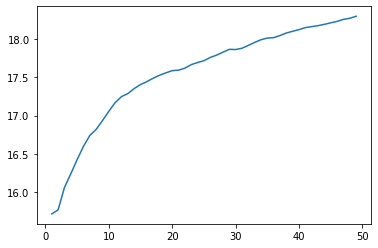

In [ ]:
plt.plot(range(1,len(k_val)+1), k_val);

k = 1 seems to better than the previous default value of 5

In [ ]:
knn_base_1 = KNeighborsRegressor(n_neighbors=1)

In [ ]:
run_model(knn_base_1, save=True)

KNeighborsRegressor test RMSE: 15.71534362407155 train RMSE: 1.5439116026856632


This seems to give better result than Linear Regression but it is highly overfitted on train data

### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def find_n_estimators(n_max):
    error = []
    for n in range(100,n_max,200):
        rfg = RandomForestRegressor(n_estimators=n, random_state=101, n_jobs=-1)
        rfg.fit(X_train, y_train)
        error.append(np.sqrt(mean_squared_error(y_test, rfg.predict(X_test))))
    return error

In [ ]:
error = find_n_estimators(2000)

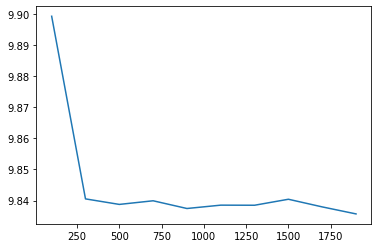

In [ ]:
plt.plot(range(100,2000,200), error);

- optimum value of n_estimators is around 400

In [ ]:
rfg_base = RandomForestRegressor(n_estimators=400, random_state=101)

In [ ]:
run_model(rfg_base, save=True)

RandomForestRegressor test RMSE: 9.83973878183564 train RMSE: 3.80122008290703


- Let's perform the grid search on the parameters of the model

#### Grid Search

In [ ]:
rfg_grid_base = RandomForestRegressor(n_estimators=400, random_state=101)

In [ ]:
param_grid = {
                'max_features': [ 1,'sqrt', 'log2', None],
                'max_depth': [4, 8, 12,None],
                'min_samples_split': [2, 7,  10],
                'min_samples_leaf': [1,  6, 10]
}

In [ ]:
rfg_grid_1 = run_gridsearch(rfg_grid_base, param_grid, save=False, n_jobs=-1)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
RandomForestRegressor test RMSE: 9.83973878183564 train RMSE: 3.80122008290703 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


- It's almost the same result, hence moving towards the next

### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dt_base = DecisionTreeRegressor(random_state=101)

In [ ]:
run_model(dt_base, save=True)

DecisionTreeRegressor test RMSE: 12.967842390686709 train RMSE: 1.0805400730355519


- This is overfitting to the train data, let's check another model

In [ ]:
performance.to_csv('data/performance.csv', index=False)

### XGBRegressor

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_base = XGBRegressor( random_state=101)

In [ ]:
run_model(xgb_base, save=True)

XGBRegressor test RMSE: 11.153442124487407 train RMSE: 7.636570223825932


- finding the optimal value of n_estimators

In [ ]:
def find_n_estimator(n_max):
    error = []
    error_train = []
    for n in range(100,n_max,100):
        xgb = XGBRegressor(n_estimators=n, random_state=101,n_jobs=-1)
        xgb.fit(X_train, y_train)
        error.append(np.sqrt(mean_squared_error(y_test, xgb.predict(X_test))))
        error_train.append(np.sqrt(mean_squared_error(y_train, xgb.predict(X_train))))
    return error,error_train

In [ ]:
error_test,error_train = find_n_estimator(800)

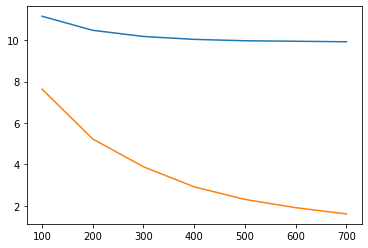

In [ ]:
plt.plot(range(100,800,100), error_test);
plt.plot(range(100,800,100), error_train);

- We can use that n_estimators = 250, to avoid the overfitting

In [ ]:
xgb_base.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=101,
             reg_alpha=0, reg_lambda=1, ...)>

#### Grid Search

In [ ]:
xgb_grid_base = XGBRegressor(random_state=101,eval_metric='rmse')

In [ ]:
param_grid = {'max_depth': [3,6,7],
                'learning_rate': [ 0.01, 0.1,  1],
                'min_child_weight': [1, 5, 9],
                'gamma': [0, 0.01, 0.1, 0.9, 1],
                'n_estimators': [250]
}

In [ ]:
xgb_grid_1 = run_gridsearch(xgb_grid_base, param_grid, save=False, n_jobs=-1)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
XGBRegressor test RMSE: 10.610680114989963 train RMSE: 6.69333125319438 {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 250}


- let's try to more tune the hyperparameters

In [ ]:
param_grid = {'max_depth': [7,8],
                'learning_rate': [0.1],
                'min_child_weight': [1,2],
                'gamma': [0.01,0.03,0.06],
                'reg_alpha': [0, 0.01, 0.1, 0.9, 1],
                'reg_lambda': [0, 0.01, 0.1, 0.9, 1],
                'n_estimators': [250]
}

In [ ]:
xgb_grid_2 = run_gridsearch(xgb_grid_base, param_grid, save=False, n_jobs=-1)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
XGBRegressor test RMSE: 9.935892490096593 train RMSE: 4.6134399584340935 {'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0}


- let's try to narrow down more

In [ ]:
param_grid = {'max_depth': [8],
                'learning_rate': [0.1],
                'min_child_weight': [1],
                'gamma': [0.03],
                'reg_alpha': [0.95, 1],
                'reg_lambda': [0,0.005],
                'n_estimators': [350]
}

In [ ]:
performance

,model,rmse_test,rmse_train
0,LinearRegression,16.970842,16.634886
1,ElasticNet,16.971049,16.634899
2,KNeighborsRegressor,15.715344,1.543912
3,RandomForestRegressor,9.839739,3.801220
4,DecisionTreeRegressor,12.967842,1.080540
5,XGBRegressor,11.153442,7.636570


In [ ]:
xgb_grid_3 = run_gridsearch(xgb_grid_base, param_grid, save=True, n_jobs=-1, model_name='XGB Grid')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
XGB Grid test RMSE: 9.674704503565655 train RMSE: 3.4221354335342555 {'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 350, 'reg_alpha': 1, 'reg_lambda': 0}


In [ ]:
performance.to_csv('data/performance.csv',index=False)

- We got two Model with better result (Random Forest grid & xgb_grid_3) hence making an  ensemble of both the models

### VotingRegressor

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
performance

,model,rmse_test,rmse_train
0,LinearRegression,16.970842,16.634886
1,ElasticNet,16.971049,16.634899
2,KNeighborsRegressor,15.715344,1.543912
3,RandomForestRegressor,9.839739,3.801220
4,DecisionTreeRegressor,12.967842,1.080540
5,XGBRegressor,11.153442,7.636570
6,XGB Grid,9.674705,3.422135


In [ ]:
rfg = RandomForestRegressor(max_depth= None, max_features= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators=400)

xgb = XGBRegressor(gamma= 0.03, learning_rate= 0.1, max_depth= 8, min_child_weight= 1, n_estimators= 350, reg_alpha= 1, reg_lambda= 0, eval_metric='rmse')

In [ ]:
vr_base = VotingRegressor(estimators=[('xgb', xgb), ('rfg', rfg)], weights=[1.5,1])

In [ ]:
run_model(vr_base, save=False)

VotingRegressor test RMSE: 9.50256406646341 train RMSE: 3.3453973166067374


# Final Model

- as we have seen that XGBRegressor with some tunned parameters is the best model, so we will use that model for our final model

In [ ]:
df = pd.read_csv('data/train_filled_scaled.csv')
X_ = df.drop(['offer_per','final_price'], axis=1)
y_ = df['offer_per']
test = pd.read_csv('data/test_filled_scaled.csv')

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [ ]:
rfg = RandomForestRegressor(max_depth= None, max_features= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators=400)

In [ ]:
xgb = XGBRegressor(gamma= 0.03, learning_rate= 0.1, max_depth= 8, min_child_weight= 1, n_estimators= 350, reg_alpha= 1, reg_lambda= 0, eval_metric='rmse')

In [ ]:
final_model = VotingRegressor(estimators=[('xgb', xgb), ('rfg', rfg)], weights=[1.5,1])

In [ ]:
def set_order(df, indexing):
    new_df = pd.DataFrame(columns=['id','price1'])
    for i in range(len(indexing)):
        new_df.loc[i] = [int(indexing[i]), int(round(df[df['id'] == indexing[i]]['price1'].values[0],-1)-1)]
    return new_df

In [ ]:
def provide_final_output(X,y,test, model):
    model.fit(X,y)

    id = test.id.values
    actual_price = np.exp(test.actual_price.values)

    test_final = test.drop(['id'], axis=1)

    
    pred = model.predict(test_final)
    price1 = actual_price*(1-pred/100)
    submit = pd.DataFrame({'id':id,'offer_per':pred,'price1':price1})
    
    indexing = pd.read_csv("data/Sample__submission.csv")['id']
    submit  = set_order(submit, indexing)
    
    return submit

In [ ]:
s = provide_final_output(X_,y_,test, final_model)

In [ ]:
s.to_csv('submit.csv', index=False)